## Predicción en el precio de automóviles
<ol>
<li>Entender y explorar los datos</li>
<li>Limpieza de datos (DQ)</li>
<li>Preparación de los datos</li>
<li>Selección de variables mediante Random Forest y Regresión</li>
<li>Validación de supuestos y remoción de outliers</li>
<li>Re-construir el modelo con los cambios hechos en 5. Seleccionar variables con K-fold cross-validation y RF</li>
    <li>Ver multicolinealidad y evaluación</li>

</ol>

## 1. Entender y explorar los datos

In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [227]:
cars=pd.read_csv("CarPrice.csv")

In [228]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

In [229]:
cars.head()

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


## Entendiendo los datos

In [230]:
# symboling: <2 (menos riesgoso) a >3 mas riesgoso
# cars: son 0,1,2
cars.symboling.value_counts()

 0    67
 1    54
 2    32
 3    27
-1    22
-2     3
Name: symboling, dtype: int64

In [231]:
#aspiration:una propiedad del motor (de combustión interna) que muestra si la ingesta de oxígeno es estándar
#(presión atmosférica) o o mediante turboalimentación (consumo de oxígeno a presión).
cars.aspiration.value_counts()


std      168
turbo     37
Name: aspiration, dtype: int64

In [232]:
# drivewheel: frontwheel, rear wheel o four-wheel drive 
cars.drivewheel.value_counts()

fwd    120
rwd     76
4wd      9
Name: drivewheel, dtype: int64

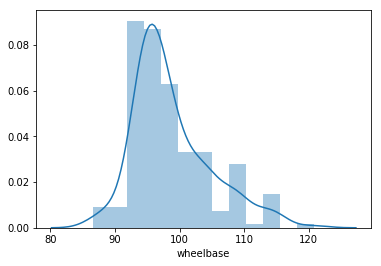

In [233]:
# wheelbase: distancia entre el centro de las ruedas delanteras y traseras
sns.distplot(cars['wheelbase'])
plt.show()

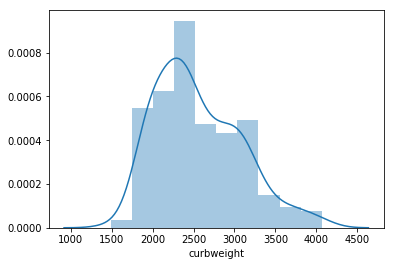

In [234]:
# curbweight: peso del auto sin ocupantes
sns.distplot(cars["curbweight"])
plt.show()

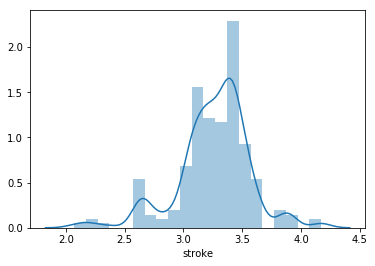

In [235]:
#stroke: volume of the engine
sns.distplot(cars["stroke"])
plt.show()

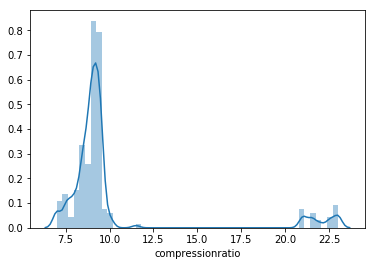

In [236]:
# compression ration:  relación del volumen de compresión de mayor capacidad a menor
sns.distplot(cars["compressionratio"])
plt.show()

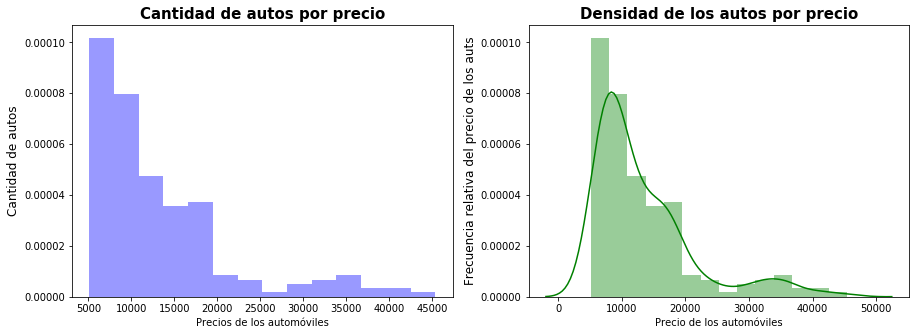

In [237]:
# variable objetivo
fig, ax= plt.subplots(1,2,figsize=(15,5)) #generar dos gráficos

sns.distplot(cars['price'], norm_hist=True, kde=False, ax=ax[0], color='blue') #primer gráfico, kde=Linea de densidad,parte de 0
ax[0].set_xlabel('Precios de los automóviles')
ax[0].set_ylabel('Cantidad de autos',size=12)
ax[0].set_title('Cantidad de autos por precio',size=15,weight="bold")

sns.distplot(cars['price'], kde=True, ax=ax[1], color='green')
ax[1].set_xlabel('Precio de los automóviles')
ax[1].set_ylabel('Frecuencia relativa del precio de los auts',size=12)
ax[1].set_title('Densidad de los autos por precio',size=15,weight="bold")
plt.show()

In [238]:
#cantidad de autos con precios sobre los 10000
caros=sum(i > 10000 for i in cars["price"])
caros
por_caros=caros/len(cars)*100
re="la cantidad de autos con precios mayores a 10000 son %s y representan el %s " %(caros,por_caros)
print(re+"%")

la cantidad de autos con precios mayores a 10000 son 105 y representan el 51.21951219512195 %



## Observaciones respecto a la variable respuesta
1. Como es de esperar los precios tienen un comportamiento positivo, con mucha concentración hacia el lado izquierdo, es decir, hacia los precios bajos


2. Más del 50% de los autos tiene un valor mayor a 10000


3. Se puede apreciar en el gráfico dos que los autos entre los 5000 y los 25000 tienen una distribución distinta a los mayores a 30.

## Exploración de Datos

In [239]:
cars_numeric=cars.select_dtypes(include=['float64','int64'])
cars_numeric.head()

,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


In [240]:
#Excluir ID y symboling, el segundo es categorico
cars_numeric = cars_numeric.drop(['symboling', 'car_ID'], axis=1)
cars_numeric.head()

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x000001D3267AAE18> (for post_execute):


KeyboardInterrupt: 

<Figure size 1440x720 with 0 Axes>

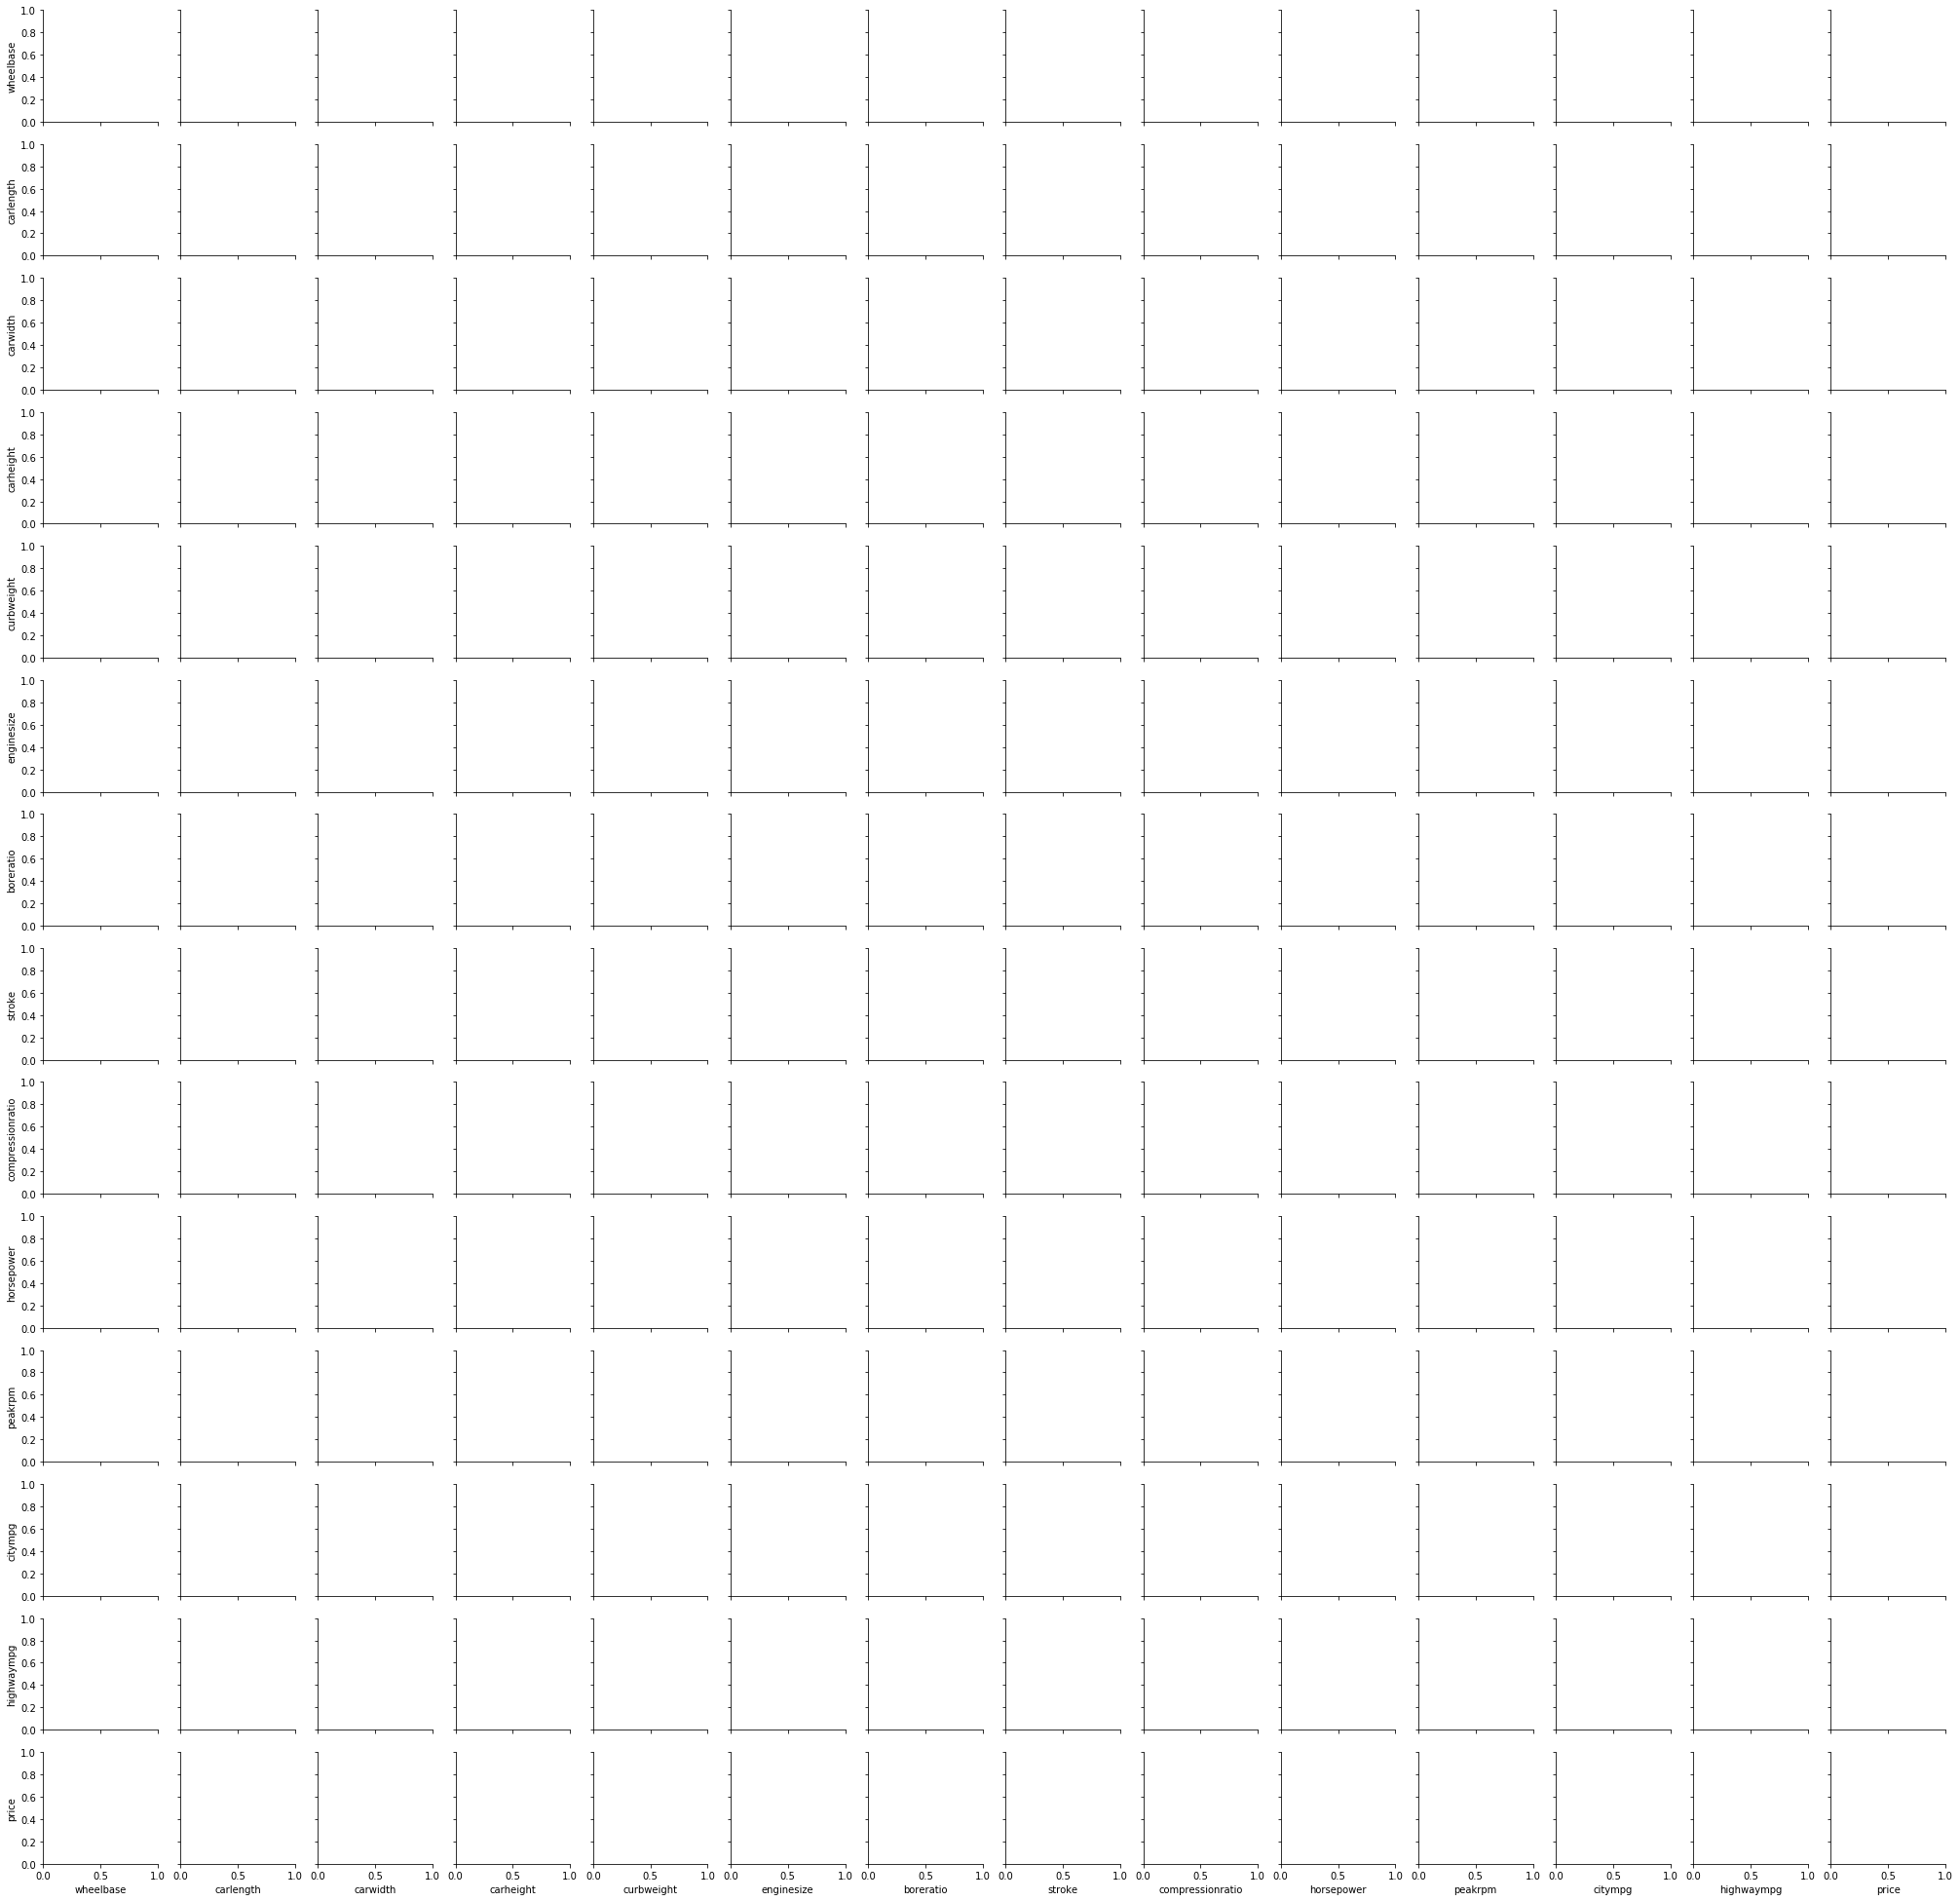

In [242]:
# pairwise scatter plot, verificar la relación lineal de nuestras variables
plt.figure(figsize=(20, 10))
sns.pairplot(cars_numeric)
#Los gráficos no se pueden observar bien por la cantidad de variables, mejor gráficar cada una por separado

In [ ]:
for i,col in enumerate (cars_numeric.columns):
    plt.figure(i)
    sns.scatterplot(x=cars_numeric[col],y=cars_numeric["price"])

1. Las variables que parecen tener una relación lineal con price es: carwidth, curbweight, enginesize, horsepower, boreration and citympg.
2. Esta posible linealidad será probada más adelante

## Matriz de Correlación 

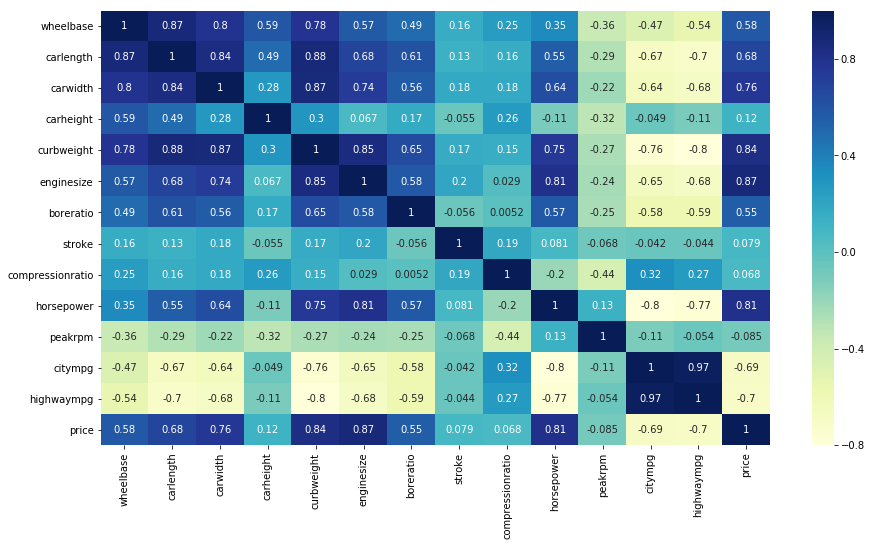

In [243]:
corr=cars_numeric.corr()
plt.figure(figsize=(15,8))
sns.heatmap(corr,annot=True,cmap="YlGnBu")
plt.show()

## Insighs del mapa de correlaciones

**1. Correlación entre Price y las variables independientes** 

* Correlación positiva: Price correlaciona positivamente con enginesize, curbweight, horsepower, carwidth
* Correlación Negativa: Price correlaciona negativmente con mpg var's citympg y highwaympg

**2. Correlación entre variables independientes**


Muchas variables independientes poseen una alta correlación entre ellas , como wheelbase, carlength, curbweight, enginesize, etc. Es importante tener esto en consideración ya que una correlación mayor al 70-80% significa una posible multicolinealidad en nuestro modelo ( que se verá más adelante con el VIF).

## Limpieza de datos: ver datos faltantes y tipos de variables

In [244]:
cars.info()
#ningun valor missing
#symboling no esta catalogado como categrico, hay que cambiarlo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null int64
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm      

In [245]:
#convertir symboling en categorico
cars['symboling']=cars['symboling'].astype('object')
cars.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null object
CarName             205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm     

In [246]:
#Extraer nombres de los autos
carnames = cars['CarName'].apply(lambda x: x.split(" ")[0])
carnames[:10]

0    alfa-romero
1    alfa-romero
2    alfa-romero
3           audi
4           audi
5           audi
6           audi
7           audi
8           audi
9           audi
Name: CarName, dtype: object

In [247]:
cars['car_company']=carnames
cars['car_company'].value_counts()
# existen varios valores duplicados

toyota         31
nissan         17
mazda          15
honda          13
mitsubishi     13
subaru         12
volvo          11
peugeot        11
volkswagen      9
dodge           9
bmw             8
buick           8
plymouth        7
audi            7
saab            6
porsche         4
isuzu           4
jaguar          3
chevrolet       3
alfa-romero     3
renault         2
maxda           2
vw              2
vokswagen       1
mercury         1
porcshce        1
Nissan          1
toyouta         1
Name: car_company, dtype: int64

In [248]:


#volkswagen
cars.loc[(cars['car_company']=="vw")|(cars['car_company']=="vokswagen"),"car_company"]="volkswagen"

#porsche

cars.loc[(cars['car_company']=="porcshce"),"car_company"]="porsche"

#toyota
cars.loc[(cars['car_company']=="toyouta"),"car_company"]="toyota"

# nissan
cars.loc[cars['car_company'] == "Nissan", 'car_company'] = 'nissan'

# mazda
cars.loc[cars['car_company'] == "maxda", 'car_company'] = 'mazda'

cars['car_company'].value_counts()



toyota         32
nissan         18
mazda          17
honda          13
mitsubishi     13
volkswagen     12
subaru         12
volvo          11
peugeot        11
dodge           9
bmw             8
buick           8
audi            7
plymouth        7
saab            6
porsche         5
isuzu           4
chevrolet       3
jaguar          3
alfa-romero     3
renault         2
mercury         1
Name: car_company, dtype: int64

In [249]:
# drop carname 
cars = cars.drop('CarName', axis=1)

In [250]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
car_ID              205 non-null int64
symboling           205 non-null object
fueltype            205 non-null object
aspiration          205 non-null object
doornumber          205 non-null object
carbody             205 non-null object
drivewheel          205 non-null object
enginelocation      205 non-null object
wheelbase           205 non-null float64
carlength           205 non-null float64
carwidth            205 non-null float64
carheight           205 non-null float64
curbweight          205 non-null int64
enginetype          205 non-null object
cylindernumber      205 non-null object
enginesize          205 non-null int64
fuelsystem          205 non-null object
boreratio           205 non-null float64
stroke              205 non-null float64
compressionratio    205 non-null float64
horsepower          205 non-null int64
peakrpm             205 non-null int64
citympg      

## 3. Preparación de datos

In [251]:
#X=independientes
#Y=respuesta
X=cars.drop(columns=["price","car_ID"])
y=cars["price"]

In [274]:
#creando dummys, primero seleccionamos las variables categoricas (object)
cars_categorical = X.select_dtypes(include=['object'])
cars_categorical.head(2)

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,car_company
0,3,gas,std,two,convertible,rwd,front,dohc,four,mpfi,alfa-romero
1,3,gas,std,two,convertible,rwd,front,dohc,four,mpfi,alfa-romero


In [275]:
#dummys
cars_dummies = pd.get_dummies(cars_categorical, drop_first=True)
cars_dummies.head()

,symboling_-1,symboling_0,symboling_1,symboling_2,symboling_3,fueltype_gas,aspiration_turbo,doornumber_two,carbody_hardtop,carbody_hatchback,...,car_company_nissan,car_company_peugeot,car_company_plymouth,car_company_porsche,car_company_renault,car_company_saab,car_company_subaru,car_company_toyota,car_company_volkswagen,car_company_volvo
0,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [276]:
X=X.drop(columns=cars_categorical)
X.head(2)

,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
1,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27


In [278]:
cars_dummies.columns

Index(['symboling_-1', 'symboling_0', 'symboling_1', 'symboling_2',
       'symboling_3', 'fueltype_gas', 'aspiration_turbo', 'doornumber_two',
       'carbody_hardtop', 'carbody_hatchback', 'carbody_sedan',
       'carbody_wagon', 'drivewheel_fwd', 'drivewheel_rwd',
       'enginelocation_rear', 'enginetype_dohcv', 'enginetype_l',
       'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'car_company_audi',
       'car_company_bmw', 'car_company_buick', 'car_company_chevrolet',
       'car_company_dodge', 'car_company_honda', 'car_company_isuzu',
       'car_company_jaguar', 'car_company_mazda', 'car_company_mercury',
       'car_company_mitsubishi', 'car_compa

In [307]:


dfX=pd.merge(X,cars_dummies,on=X.index)
dfX.columns



Index(['key_0', 'wheelbase', 'carlength', 'carwidth', 'carheight',
       'curbweight', 'enginesize', 'boreratio', 'stroke', 'compressionratio',
       'horsepower', 'peakrpm', 'citympg', 'highwaympg', 'symboling_-1',
       'symboling_0', 'symboling_1', 'symboling_2', 'symboling_3',
       'fueltype_gas', 'aspiration_turbo', 'doornumber_two', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginelocation_rear', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'car_company_audi',
       'car_company_bmw', 'car_company_buick', 'car_company_che

In [308]:
dfX.drop(columns='key_0',inplace=True)
dfX.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 68 columns):
wheelbase                 205 non-null float64
carlength                 205 non-null float64
carwidth                  205 non-null float64
carheight                 205 non-null float64
curbweight                205 non-null int64
enginesize                205 non-null int64
boreratio                 205 non-null float64
stroke                    205 non-null float64
compressionratio          205 non-null float64
horsepower                205 non-null int64
peakrpm                   205 non-null int64
citympg                   205 non-null int64
highwaympg                205 non-null int64
symboling_-1              205 non-null uint8
symboling_0               205 non-null uint8
symboling_1               205 non-null uint8
symboling_2               205 non-null uint8
symboling_3               205 non-null uint8
fueltype_gas              205 non-null uint8
aspiration_turbo          

## Escalamiento de variables

In [309]:

from sklearn.preprocessing import scale
cols=dfX.columns
dfX_scaled=pd.DataFrame(scale(dfX))
dfX_scaled.columns=cols
dfX_scaled.columns

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by the scale function.
  after removing the cwd from sys.path.


Index(['wheelbase', 'carlength', 'carwidth', 'carheight', 'curbweight',
       'enginesize', 'boreratio', 'stroke', 'compressionratio', 'horsepower',
       'peakrpm', 'citympg', 'highwaympg', 'symboling_-1', 'symboling_0',
       'symboling_1', 'symboling_2', 'symboling_3', 'fueltype_gas',
       'aspiration_turbo', 'doornumber_two', 'carbody_hardtop',
       'carbody_hatchback', 'carbody_sedan', 'carbody_wagon', 'drivewheel_fwd',
       'drivewheel_rwd', 'enginelocation_rear', 'enginetype_dohcv',
       'enginetype_l', 'enginetype_ohc', 'enginetype_ohcf', 'enginetype_ohcv',
       'enginetype_rotor', 'cylindernumber_five', 'cylindernumber_four',
       'cylindernumber_six', 'cylindernumber_three', 'cylindernumber_twelve',
       'cylindernumber_two', 'fuelsystem_2bbl', 'fuelsystem_4bbl',
       'fuelsystem_idi', 'fuelsystem_mfi', 'fuelsystem_mpfi',
       'fuelsystem_spdi', 'fuelsystem_spfi', 'car_company_audi',
       'car_company_bmw', 'car_company_buick', 'car_company_chevrolet',


In [311]:
# No es estrictamente necesario, pero si recomendable para facilitar la interpretación
#from sklearn.preprocessing import scale
# almacenar nombres de columna en columnas, ya que los nombres de columna se pierden (molestamente) después de  
#escalado (el df se convierte en una matriz numpy)



# dividir dataset en train y test
from sklearn.model_selection import train_test_split
a=X_train, X_test, y_train, y_test = train_test_split(dfX_scaled, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)



## 4. Modelamiento de datos
Como se ve en las secciones anteriores, "price" presenta una relación lineal, por lo que se realizara una regresión lineal


In [313]:
#Modelos con todas las variables
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

lm=LinearRegression()
lm.fit(X_train,y_train)
y_pred_test=lm.predict(X_test)
y_pred_train=lm.predict(X_train)

In [314]:
# Métricas de evaluación

# R Cuadrado
from sklearn.metrics import r2_score


print('R-Cuadrado de la data de entrenamiento es de : {}'.format(r2_score(y_true=y_train, y_pred=y_pred_train)))
print('R-Cuadrado de la data test es de : {}'.format(r2_score(y_true=y_test, y_pred=y_pred_test)))

#RMSE= Raíz del error cuadrático medio
error_train=y_pred_train-y_train
error_test=y_pred_test-y_test

print('RMSE en train data: {}'.format(((error_train**2).mean())**0.5))
print('RMSE en test data: {}'.format(((error_test**2).mean())**0.5))

R-Cuadrado de la data de entrenamiento es de : 0.9756892503873289
R-Cuadrado de la data test es de : 0.8382621393399063
RMSE en train data: 1213.0021196738403
RMSE en test data: 3365.4652343880953


**Overfitting: Claramente el modelo esta sobreajustado, esto se debe principalmente a que estamos ocupando todas las variables, por lo que procedemos a disminuir la dimensionalidad**

## Elimiminación recursiva de variables (RFE)

In [315]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm

n_features_list = list(range(4, 31)) #Número de variables óptimos entre 4 a 30
train_adjusted_r2 = []
train_r2 = []
test_r2 = []
train_RMSE=[]
test_RMSE=[]

for n_features in range(4, 31):

    # RFE con las n variables
    lm = LinearRegression()

    # Especificar el número de variables
    rfe_n = RFE(estimator=lm, n_features_to_select=n_features)

    # ajuste con n variables
    rfe_n.fit(X_train, y_train)

    # rfe_n= Selección de variables
    col_n = X_train.columns[rfe_n.support_] #rfe_n.support_: devuelve una matriz con valores booleanos para indicar si
     #Se seleccionó un atributo usando RFE

    # train & test data para las n columnas seleccionadas
    X_train_rfe_n = X_train[col_n]
    X_test_rfe_n = X_test[col_n]


    # Agregar constante al modelo 
    X_train_rfe_n = sm.add_constant(X_train_rfe_n)


    X_test_rfe_n = sm.add_constant(X_test_rfe_n, has_constant='add')

    
    
    # Ajustando el modelos con las n variables
    lm_n = sm.OLS(y_train, X_train_rfe_n).fit()
    
    
    # # Creando las predicciones
    y_pred_test = lm_n.predict(X_test_rfe_n)
    y_pred_train = lm_n.predict(X_train_rfe_n)
    
    
    #Metricas de evaluaciónn
    
    #R-square
    train_adjusted_r2.append(lm_n.rsquared_adj)
    train_r2.append(lm_n.rsquared)
    test_r2.append(r2_score(y_test, y_pred_test))
    
    #RMSE/stan. error
    error_test=y_pred_test-y_test
    error_train=y_pred_train-y_train
    
    test_RMSE.append(((error_test**2).mean())**0.5)
    train_RMSE.append(((error_train**2).mean())**0.5)

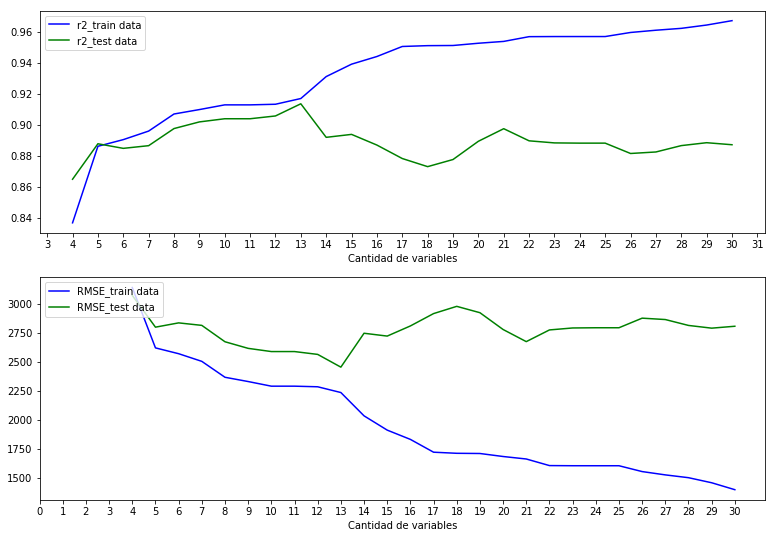

In [316]:
# Graficando r2 y RMSE con las n variables seleccionadas
import matplotlib.ticker as plticker

fig,ax=plt.subplots(2,1,figsize=(13, 9))
ax[0].plot(n_features_list, train_r2,'b', label="r2_train data")
ax[0].plot(n_features_list, test_r2,'g', label="r2_test data")
ax[0].set_xlabel('Cantidad de variables')

ax[0].legend(loc='upper left')
loc = plticker.MultipleLocator(base=1)
ax[0].xaxis.set_major_locator(loc) #method 1 of ticks

ax[1].plot(n_features_list, train_RMSE, 'b',label="RMSE_train data")
ax[1].plot(n_features_list, test_RMSE, 'g',label="RMSE_test data")
ax[1].set_xlabel('Cantidad de variables')


ax[1].legend(loc='upper left')
plt.xticks(np.arange(0, 31, step=1))#method 2 of ticks

plt.show()

 Tanto r2 y RMSE muestran que 23
variables sería lo ideal

## Modelo con las variables óptimas

In [319]:
lm=LinearRegression()
rfe=RFE(lm,13)
rfe.fit(X_train,y_train)

col=X_train.columns[rfe.support_] #obtaining fetaure names of 12 most imp 

#making new Df's with  12 most imp features as per RFE algorithm
X_train_13= X_train[col]
X_test_13 = X_test[col]


# add a constant to the model
X_train_13 = sm.add_constant(X_train_13,has_constant='add')
X_test_13 = sm.add_constant(X_test_13,has_constant='add')


#fit OLS model
lm_sm=sm.OLS(y_train,X_train_13).fit()


#making predictions
y_pred_train=lm_sm.predict(X_train_13)
y_pred_test=lm_sm.predict(X_test_13)


#evlaution metrics

#R-sqaure
train_r2=lm_sm.rsquared
test_r2=r2_score(y_pred_test, y_test)

#RMSE/stan. error
error_test=y_pred_test-y_test
error_train=y_pred_train-y_train
    
test_RMSE=(((error_test**2).mean())**0.5)
train_RMSE=(((error_train**2).mean())**0.5)

print('----------------------R-Cuadrado-------------------------------------------')
print("R-sq para data test es {}".format(test_r2))
print("R-sq para data train es {}".format(train_r2))


print('----------------------RMSE-------------------------------------------')
print("RMSE para data test es {}".format(test_RMSE))
print("RMSE para data train es {}".format(train_RMSE))

print(lm_sm.summary())

----------------------R-Cuadrado-------------------------------------------
R-sq para data test es 0.9006167424476531
R-sq para data train es 0.9172871967113265
----------------------RMSE-------------------------------------------
RMSE para data test es 2455.655255247883
RMSE para data train es 2237.426382098871
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.917
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     120.1
Date:                Wed, 18 Mar 2020   Prob (F-statistic):           3.47e-64
Time:                        17:53:31   Log-Likelihood:                -1305.9
No. Observations:                 143   AIC:                             2638.
Df Residuals:                     130   BIC:                             2676.
Df Model:                          12                 

### Observaciones:
* El r2 de train y data son bastantes similares
* el RMSE tambien se ve bastante bien
* Existe multicolinealidad, por lo tanto se viola este supuesto y es algo que hay que tener en cuenta

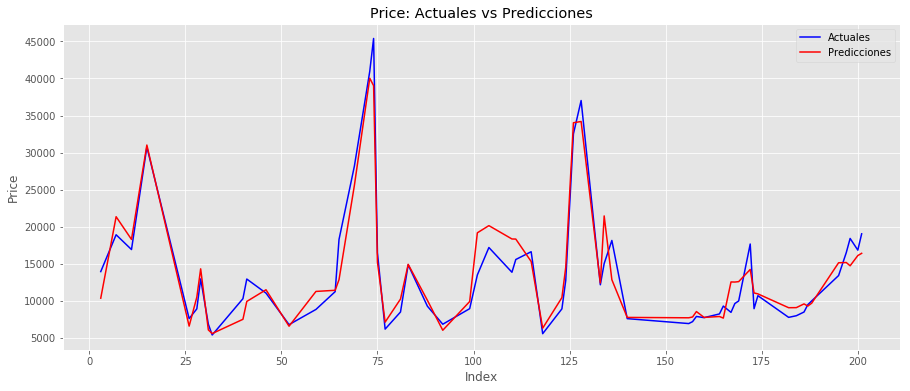

In [321]:


plt.style.use('ggplot')
fig, ax=plt.subplots(figsize=(15,6))
sns.lineplot(x=y_test.index,y=y_test,label='Actuales',color='blue',ax=ax)
sns.lineplot(x=y_test.index,y=y_pred_test,label='Predicciones',color='red',ax=ax)
ax.set_title('Price: Actuales vs Predicciones')
ax.set_ylabel('Price')
ax.set_xlabel('Index')
plt.show()


In [322]:
#Guardando las variables importantes 
features_13=lm_sm.params.index
features_13=features_13[1:] #Excluimos las constante
features_13

Index(['carwidth', 'curbweight', 'enginesize', 'boreratio', 'stroke',
       'enginelocation_rear', 'enginetype_rotor', 'cylindernumber_five',
       'cylindernumber_four', 'cylindernumber_twelve', 'cylindernumber_two',
       'car_company_bmw', 'car_company_porsche'],
      dtype='object')

In [323]:
X_train[features_13].head(2)

,carwidth,curbweight,enginesize,boreratio,stroke,enginelocation_rear,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_twelve,cylindernumber_two,car_company_bmw,car_company_porsche
122,-0.984972,-0.701886,-0.695874,-1.331531,-0.081241,-0.121867,-0.141069,-0.23812,0.537874,-0.070014,-0.141069,-0.201517,-0.158114
125,1.117866,0.428245,0.579974,2.258638,-0.464834,-0.121867,-0.141069,-0.23812,0.537874,-0.070014,-0.141069,-0.201517,6.324555


## 5. Validación de Supuestos del modelo de regresión

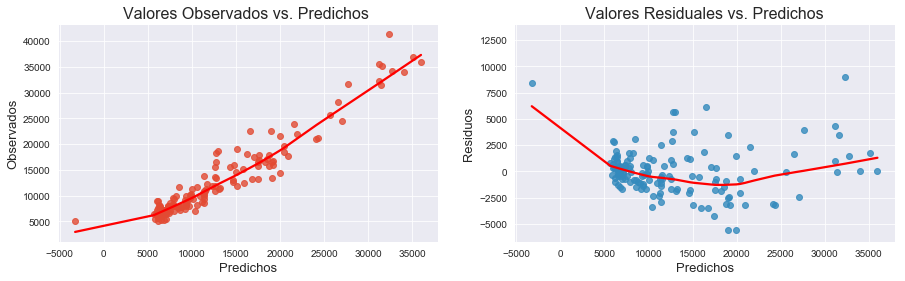

In [324]:
#Para detectar linealidad observamos el gráfico de valores predichos vs observados o residuos vs predichos
#El resultado debe ser una distribución simétrica alrededor de la diagonal

def linearity_test(model, y):
    
    fitted_vals = model.predict()
    residuals = model.resid
    
    sns.set_style('darkgrid')
    fig,ax=plt.subplots(1,2, figsize=(15,4))
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Valores Observados vs. Predichos ', fontsize=16)
    ax[0].set_xlabel('Predichos', fontsize=13)
    ax[0].set_ylabel('Observados', fontsize=13)
    
    sns.regplot(x=fitted_vals,y=residuals,lowess=True,ax=ax[1],line_kws={'color': 'red'})
    ax[1].set_title('Valores Residuales vs. Predichos', fontsize=16)
    ax[1].set_xlabel('Predichos', fontsize=13)
    ax[1].set_ylabel('Residuos', fontsize=13)
    
linearity_test(lm_sm, y_train)

### Observaciones
* EL primer gráfico de valores observaos vs predichos muestra una cierta linealidad salvo algunos datos que podrian ser influyentes
* EL segundo gráfico de residuales vs predichos ya deja entrever una cierta falta de linealidad y varios valores influyentes

## Homocedasticidad de los residuos

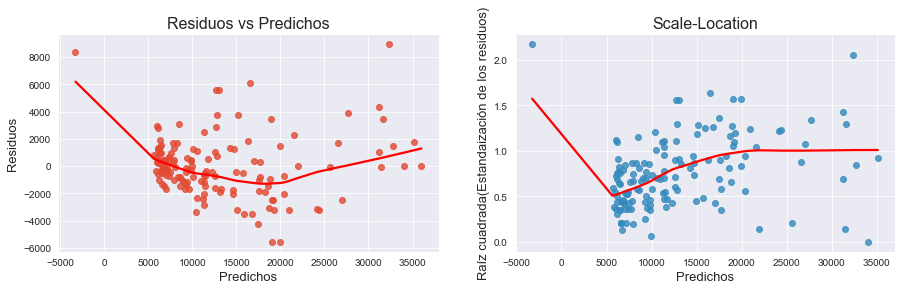

In [325]:
# La varianza de los errores debe ser constante (la misma en todos los niveles de las variables independientes)
# Este supuesto puede ser testeado mediante un gráfico de la estandarización de los residuos por la estandarización de las predicciones

import statsmodels.stats.api as sms

def homoscedasticity_test(model):
    
    fitted_vals = model.predict()
    residuals = model.resid
    resids_standardized = model.get_influence().resid_studentized_internal
    
    sns.set_style('darkgrid')
    
    
    fig, ax = plt.subplots(1,2,figsize=(15,4))

    sns.regplot(x=fitted_vals, y=residuals, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Residuos vs Predichos', fontsize=16)
    ax[0].set_xlabel('Predichos', fontsize=13)
    ax[0].set_ylabel('Residuos', fontsize=13)

    sns.regplot(x=fitted_vals, y=np.sqrt(np.abs(resids_standardized)), lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Scale-Location', fontsize=16)
    ax[1].set_xlabel('Predichos', fontsize=13)
    ax[1].set_ylabel('Raíz cuadrada(Estandaización de los residuos)', fontsize=13)

      
homoscedasticity_test(lm_sm)



**Los gráficos muestran una falta de homogeneidad (heterocedasticidad). Esto podría solucionarse eliminando ls datos outliers o influyentes**

## Normalidad de los residuos

Si se viola este supuesto, los intervalos de confianza y los test de significancia de los coeficientes del modelo son imprecisos.

Razones de porque no se puede cumplir este supuesto:
* Valores Outliers
* Mala especificación del modelo
* Incumplimiento de otros supuestos

Jarque-Bera test ---- Estadístico: 61.7387, p-value: 3.9190872769268026e-14
Shapiro-Wilk test ---- Estadístico: 0.9427, p-value: 0.0000
Kolmogorov-Smirnov test ---- Estadístico: 0.5455, p-value: 0.0000
Anderson-Darling test ---- Estadístico: 1.9842, 5% valor crítico: 0.7660


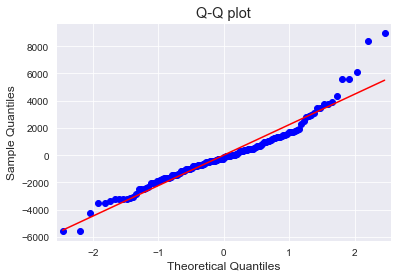

In [331]:
from scipy import stats

def normality_of_residuals_test(model):
    '''
    Function for drawing the normal QQ-plot of the residuals and running 4 statistical tests to 
    investigate the normality of residuals.
    
    Arg:
    * model - fitted OLS models from statsmodels
    '''
    
    sm.ProbPlot(model.resid).qqplot(line='s');
    plt.title('Q-Q plot');
    

    jb = stats.jarque_bera(model.resid)
    sw = stats.shapiro(model.resid)
    ad = stats.anderson(model.resid, dist='norm')
    ks = stats.kstest(model.resid, 'norm')
    
    print(f'Jarque-Bera test ---- Estadístico: {jb[0]:.4f}, p-value: {jb[1]}')
    print(f'Shapiro-Wilk test ---- Estadístico: {sw[0]:.4f}, p-value: {sw[1]:.4f}')
    print(f'Kolmogorov-Smirnov test ---- Estadístico: {ks.statistic:.4f}, p-value: {ks.pvalue:.4f}')
    print(f'Anderson-Darling test ---- Estadístico: {ad.statistic:.4f}, 5% valor crítico: {ad.critical_values[2]:.4f}') 
    
normality_of_residuals_test(lm_sm)

**El supuesto se rechaza, ya que la hipótesis nula de los 3 prímeros test y el valor de AD, se rechaza (H1: sigue una distribución normal).**

**En el gráfico se aprecia que el problema esta en las colas de la distribución, por lo tanto es necesario ver los outliers**

## Identificar outliers y valores influyentes

In [332]:
# Función para trazar residuos estandarizados vs Apalancamiento y distancia de cook para detección de valores atípicos

def influential_outlier_test(model,top_influencing_obs_count):
    
    influence = model.get_influence()

#leverage (valores hat )
    leverage = influence.hat_matrix_diag

#Cuando los casos están fuera de la distancia de Cook (lo que significa que tienen puntajes de distancia de Cook altos),
#los casos son influyentes en la regresión. Esta regresión resulta alterada si se incluyen estos datos.
    cooks_d = influence.cooks_distance

#estandarización de los residuos= (residuos/STD de residuos)
    standardized_residuals = influence.resid_studentized_internal

#Estandarización de los residuos
    studentized_residuals = influence.resid_studentized_external 
    
    
    plot_lm = plt.figure(figsize=(15,5))
    plt.scatter(leverage, standardized_residuals, alpha=0.5)
    sns.regplot(leverage, standardized_residuals,scatter=False,ci=False,lowess=True,
                line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    plot_lm.axes[0].set_xlim(0, max(leverage)+0.01)
    plot_lm.axes[0].set_ylim(-10, 6)
    plot_lm.axes[0].set_title('Residuos estandarizados vs Leverage',fontsize=16)
    plot_lm.axes[0].set_xlabel('Leverage',fontsize=13)
    plot_lm.axes[0].set_ylabel('Residuaos estandarizados',fontsize=13);

 #anotar la posición del índice de los n puntos D superiores de la distancia de cook    
    leverage_top_n_obs = np.flip(np.argsort(cooks_d[0]), 0)[:top_influencing_obs_count]  
    
    for i in leverage_top_n_obs:
        plot_lm.axes[0].annotate(i,xy=(leverage[i],studentized_residuals[i])) 
    
    
    def graph(formula, x_range, label=None):
        x = x_range
        y = formula(x)
        plt.plot(x, y, label=label, lw=1, ls='--', color='red')

    p = len(lm_sm.params) # number of model parameters

    graph(lambda x: np.sqrt((0.5 * p * (1 - x)) / x), np.linspace(0.001, max(leverage), 50),'distancia de Cook\'')#cookd= 0.5 
    plt.legend(loc='upper right');

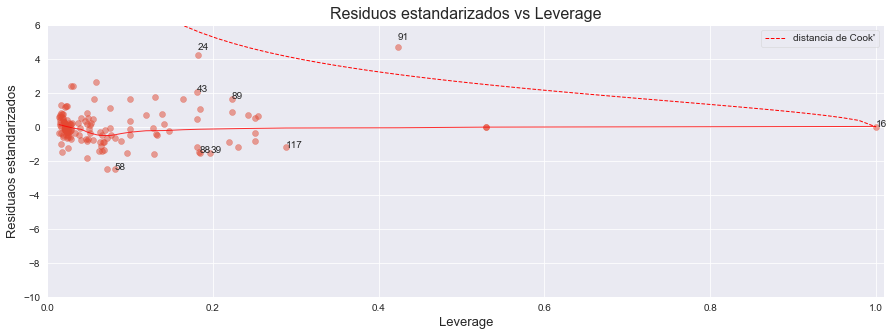

In [335]:
influential_outlier_test(model=lm_sm,top_influencing_obs_count=10)
#Se muestran los top 10  

El dato 91 y 16 estan más arriba de la distancia de cook, por lo que deben ser removidos. El dato 24 no debería ser removido, pero igual lo eliminamos por que tiene un valor residual muy alto

## Eliminando Outliers

In [337]:
X_train_no_outliers=X_train.drop(index=[16,24,91])
y_train_no_outliers=y_train.drop(index=[16,24,91])

## 6. Re-contruir el modelo: selección de variables con RFE & K-Fold Cross Validation

In [338]:
from sklearn.feature_selection import RFE
import statsmodels.api as sm

n_features_list = list(range(4, 31))
train_adjusted_r2 = []
train_r2 = []
test_r2 = []
train_RMSE=[]
test_RMSE=[]

for n_features in range(4, 31):

    # RFE con n variables
    lm = LinearRegression()

    rfe_n = RFE(estimator=lm, n_features_to_select=n_features)  # specifying number of features

    # Ajuste con  n variables
    rfe_n.fit(X_train_no_outliers, y_train_no_outliers)

    # Seleccionando las variables mediante rfe_n
    col_n = X_train_no_outliers.columns[rfe_n.support_] #

    # dividiendo data train y test  para las n columnas seleccionadas
    X_train_rfe_n = X_train_no_outliers[col_n]
    X_test_rfe_n = X_test[col_n]


    # Agregar la constante al modelo
    X_train_rfe_n = sm.add_constant(X_train_rfe_n,has_constant='add')


    X_test_rfe_n = sm.add_constant(X_test_rfe_n, has_constant='add')

    
    
    # Ajustando el modelos con n variables
    lm_n = sm.OLS(y_train_no_outliers, X_train_rfe_n).fit()
    
    
    # # Creando las predicciones
    y_pred_test = lm_n.predict(X_test_rfe_n)
    y_pred_train = lm_n.predict(X_train_rfe_n)
    
    
    #Calculando las metricas de evaluación
    
    #R-Cuadrado
    train_adjusted_r2.append(lm_n.rsquared_adj)
    train_r2.append(lm_n.rsquared)
    test_r2.append(r2_score(y_test, y_pred_test))
    
    #RMSE
    error_test=y_pred_test-y_test
    error_train=y_pred_train-y_train_no_outliers
    
    test_RMSE.append(((error_test**2).mean())**0.5)
    train_RMSE.append(((error_train**2).mean())**0.5)

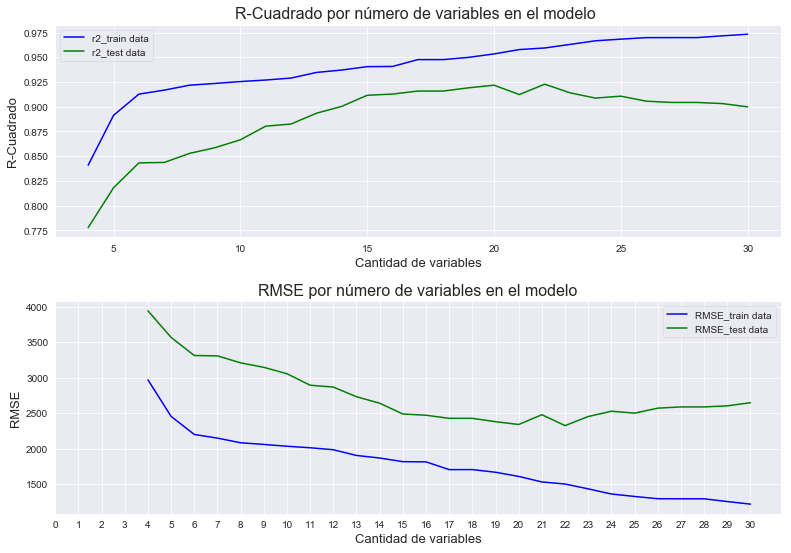

In [339]:
#gráficos de RMSE y R2

fig,ax=plt.subplots(2,1,figsize=(13, 9))
plt.subplots_adjust(hspace = 0.3)
ax[0].plot(n_features_list, train_r2,'b', label="r2_train data")
ax[0].plot(n_features_list, test_r2,'g', label="r2_test data")
ax[0].set_xlabel('Cantidad de variables',fontsize=13)
ax[0].set_ylabel('R-Cuadrado',fontsize=13)
ax[0].set_title('R-Cuadrado por número de variables en el modelo ',fontsize=16)


ax[1].plot(n_features_list, train_RMSE, 'b',label="RMSE_train data")
ax[1].plot(n_features_list, test_RMSE, 'g',label="RMSE_test data")
ax[1].set_xlabel('Cantidad de variables',fontsize=13)
ax[1].set_ylabel('RMSE',fontsize=13)
ax[1].set_title('RMSE por número de variables en el modelo',fontsize=16)

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper right')
plt.xticks(np.arange(0,31,1))

plt.show()



De los gráficos anteriores no podemos seleccionar las características óptimas para nuestro modelo porque: Hay un sobreajuste alto ya que la diferencia entre el tren y la prueba Rsquare y RMSE es muy alta, nuestro modelo no se generalizará bien y conducirá a malas predicciones en la prueba / datos no vistos .

In [341]:
# Diferencia entre train y test, lo ideal seria que fuese cercano a 1, pero como se verá, son mucho más alto que 1, por lo
#que tiene un sobreajuste alto. 

RMSE_test_dividedby_train = [i / j for i, j in zip(test_RMSE, train_RMSE)]
RMSE_test_dividedby_train

[1.3275993553602032,
 1.4534968597316589,
 1.5055980115912146,
 1.5396913319619054,
 1.5408275419255342,
 1.5276429629475448,
 1.502612790648261,
 1.437992438060575,
 1.4449613362473293,
 1.4347313411198057,
 1.4135975027177536,
 1.3697659273681158,
 1.362346947092294,
 1.423931635254986,
 1.423931635254991,
 1.4273034134168994,
 1.4549506534229288,
 1.619050538357612,
 1.5483258481025521,
 1.711638919161578,
 1.8577727121594587,
 1.8856471598621782,
 1.9862219613703977,
 2.001364269450333,
 2.001424204262972,
 2.075409529733572,
 2.1736565940907515]

Para remediar el sobreajuste / diferencia de alto rendimiento entre los datos del tren y la prueba, haremos la validación cruzada Kfold e intentaremos determinar el recuento óptimo de características

## Preparar los datos para K-Fold Cross Validation

In [356]:
# Antes de implementar K-Fold se remueven los outliers de las bases X y Dfs y se crean nuevasnes for CV purpose

X_new_cv = dfX_scaled.drop(index=[16,24,91]) # DF para K fold cross validation (cv)
y_new_cv = y.drop(index=[16,24,91])



# Restablecimiento del índice, ya que necesitamos usar K-fold y, por lo tanto, el índice debe estar en el orden correcto
X_new_cv.reset_index(inplace=True, drop=True)
X_new_cv.head(20)



,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,...,car_company_nissan,car_company_peugeot,car_company_plymouth,car_company_porsche,car_company_renault,car_company_saab,car_company_subaru,car_company_toyota,car_company_volkswagen,car_company_volvo
0,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.074449,0.519071,-1.839377,-0.288349,0.174483,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
1,-1.690772,-0.426521,-0.844782,-2.020417,-0.014566,0.074449,0.519071,-1.839377,-0.288349,0.174483,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
2,-0.708596,-0.231513,-0.190566,-0.543527,0.514882,0.604046,-2.404880,0.685946,-0.288349,1.264536,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
3,0.173698,0.207256,0.136542,0.235942,-0.420797,-0.431076,-0.517266,0.462183,-0.035973,-0.053668,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
4,0.107110,0.207256,0.230001,0.235942,0.516807,0.218885,-0.517266,0.462183,-0.540725,0.275883,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
5,0.173698,0.264133,0.183272,-0.256354,-0.093502,0.218885,-0.517266,0.462183,-0.414537,0.149133,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
6,1.172521,1.515437,2.566488,0.810288,0.555313,0.218885,-0.517266,0.462183,-0.414537,0.149133,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
7,1.172521,1.515437,2.566488,0.810288,0.767092,0.218885,-0.517266,0.462183,-0.414537,0.149133,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
8,1.172521,1.515437,2.566488,0.892338,1.021227,0.098522,-0.739338,0.462183,-0.465012,0.909635,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812
9,0.123757,0.337262,0.930947,-0.707626,0.957693,0.098522,-0.739338,0.462183,-0.793101,1.416637,...,-0.310253,-0.23812,-0.188025,-0.158114,-0.099258,-0.17364,-0.249351,-0.430083,-0.249351,-0.23812


In [357]:
y_new_cv.reset_index(drop=True,inplace=True)
y_new_cv.head(20)

0     13495.000
1     16500.000
2     16500.000
3     13950.000
4     17450.000
5     15250.000
6     17710.000
7     18920.000
8     23875.000
9     17859.167
10    16430.000
11    16925.000
12    20970.000
13    21105.000
14    24565.000
15    30760.000
16    36880.000
17     5151.000
18     6295.000
19     6575.000
Name: price, dtype: float64

In [345]:
print(X_new_cv.shape,y_new_cv.shape)


(202, 68) (202,)


## K-Fold Cross Validation

In [349]:
from sklearn.model_selection import KFold


K=5 #usando 5 folds
kf = KFold(n_splits=K, shuffle=True, random_state=42)
   
for n_features in range(5,31):
    
    train_RMSE = []
    test_RMSE = []
    train_r2=[]
    test_r2=[]
    
    for train, test in kf.split(X_new_cv):
        
        lm = LinearRegression()
        
        rfe_n = RFE(estimator=lm, n_features_to_select=n_features)
        
        rfe_n.fit(X_new_cv.loc[train],y_new_cv[train])
        
        y_pred_train=rfe_n.predict(X_new_cv.loc[train])
        y_pred_test=rfe_n.predict(X_new_cv.loc[test])
        
        #R-Cuadrado
        train_r2.append(r2_score(y_pred_train , y_new_cv[train]))
        test_r2.append(r2_score(y_pred_test , y_new_cv[test]))
        
        #Error
        error_train = y_pred_train - y_new_cv[train]
        error_test = y_pred_test - y_new_cv[test]
        rmse_train=((error_train**2).mean())**0.5
        rmse_test=((error_test**2).mean())**0.5
        
        train_RMSE.append(rmse_train)
        test_RMSE.append(rmse_test)
        
    test_times_train=np.mean(test_RMSE)/np.mean(train_RMSE)
         # Generar reporte
    print('n_features:{:1} |train_R2:{:2} |test_R2:{:3} |mean(rmse_train):{:4} |mean(rmse_test):{:5} |RMSE(test/train):{}'.
          format(n_features, round(np.mean(train_r2),4), round(np.mean(test_r2),4),
                 round(np.mean(train_RMSE),0),
                 round(np.mean(test_RMSE),0),round(test_times_train,2)))

n_features:5 |train_R2:0.8723 |test_R2:0.8138 |mean(rmse_train):2595.0 |mean(rmse_test):3180.0 |RMSE(test/train):1.23
n_features:6 |train_R2:0.8917 |test_R2:0.8278 |mean(rmse_train):2414.0 |mean(rmse_test):3100.0 |RMSE(test/train):1.28
n_features:7 |train_R2:0.9061 |test_R2:0.8345 |mean(rmse_train):2266.0 |mean(rmse_test):2997.0 |RMSE(test/train):1.32
n_features:8 |train_R2:0.913 |test_R2:0.838 |mean(rmse_train):2188.0 |mean(rmse_test):2964.0 |RMSE(test/train):1.35
n_features:9 |train_R2:0.92 |test_R2:0.8366 |mean(rmse_train):2104.0 |mean(rmse_test):2953.0 |RMSE(test/train):1.4
n_features:10 |train_R2:0.9239 |test_R2:0.8379 |mean(rmse_train):2055.0 |mean(rmse_test):2955.0 |RMSE(test/train):1.44
n_features:11 |train_R2:0.9299 |test_R2:0.8334 |mean(rmse_train):1975.0 |mean(rmse_test):2932.0 |RMSE(test/train):1.48
n_features:12 |train_R2:0.9318 |test_R2:0.8454 |mean(rmse_train):1951.0 |mean(rmse_test):2854.0 |RMSE(test/train):1.46
n_features:13 |train_R2:0.9343 |test_R2:0.8391 |mean(rmse_

De los datos anteriores encontramos:

    Nuestro modelo se sobreajusta a medida que aumentamos el número de características (a juzgar por la brecha b / w de prueba y entrenamiento RMSE y R2)
    En n_features = 5 test_RMSE es un 25% más que train_RMSE, lo que significa que nuestras predicciones sobre los datos de prueba son un 25% más inexactas (como RMSE (prueba / tren) = 1.25) y 33% incorrecto con 6 características.

Más allá de 6 características, este número es del 35% o más, lo cual es un sobreajuste masivo (incluso con el modelo de características 5/6, hay una gran brecha entre el tren y la prueba acordada por RMSE)

Para hacer frente a esto, ejecuté el modelo con 5 y 6 características y encontré multicolinealidad. Características: el ancho del vehículo y el peso en vacío están altamente correlacionados y este último tiene un VIF de 7 más. Entonces, cuando n = 6, elimino 'curbweight' dejándonos con n = 5.

MÁS DETALLES A CONTINUACIÓN.

Posible motivo del sobreajuste: PORQUE SÓLO TENEMOS OBSERVACIONES DE 200 ODD Y TOTAL DE 68 VARIABLES NO PODEMOS ESPERAR UN MODELO MUY EXACTO. Según el artículo de Jim Frost (famoso estudioso de estadísticas / blogger) sobre ajuste de regresión 

"Los estadísticos han realizado estudios de simulación * que indican que debe tener al menos 10-15 observaciones para cada término en un modelo lineal", por lo que para cumplir esta regla necesitamos un conjunto de datos mucho más grande en el que cada característica está representada adecuadamente.

## 7. Removiendo multicolinealidad, re-evaluación del modelo y validación de supuestos

In [358]:
#Modelo con 7 variables

import statsmodels.api as sm

lm = LinearRegression()

rfe = RFE(estimator=lm, n_features_to_select=7)

rfe.fit(X_new_cv, y_new_cv)

col= X_new_cv.columns[rfe.support_] 

X_final=X_new_cv[col] #X DF solo top 7

X_final= sm.add_constant(X_final,has_constant='add')

lm_sm=sm.OLS(y_new_cv,X_final).fit()

print(lm_sm.summary())



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.911
Method:                 Least Squares   F-statistic:                     296.5
Date:                Wed, 18 Mar 2020   Prob (F-statistic):          5.83e-100
Time:                        22:53:36   Log-Likelihood:                -1847.3
No. Observations:                 202   AIC:                             3711.
Df Residuals:                     194   BIC:                             3737.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                1.322e+04    

# Multicolinealidad

In [359]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

def variance_inflation_factors(X_df): #X_df = X_train normalmente, en este modelo es X=X_final
    '''
     '''
    X_df = add_constant(X_df)
    vifs = pd.Series(
        [1 / (1. - OLS(X_df[col].values, 
                       X_df.loc[:, X_df.columns != col].values).fit().rsquared) 
         for col in X_df],
        index=X_df.columns,
        name='VIF'
    )
    return vifs

In [360]:
variance_inflation_factors(X_final)

const                  1.000685
carwidth               5.021834
curbweight             6.886970
enginesize             4.334174
enginelocation_rear    1.253646
cylindernumber_four    2.576049
cylindernumber_six     2.559563
car_company_bmw        1.187550
Name: VIF, dtype: float64

curbweight  tiene un VIF alto, lo eliminamos

In [361]:
X_final =X_final.loc[:,X_final.columns !='curbweight']
X_final.head()

,const,carwidth,enginesize,enginelocation_rear,cylindernumber_four,cylindernumber_six,car_company_bmw
0,1.0,-0.844782,0.074449,-0.121867,0.537874,-0.364138,-0.201517
1,1.0,-0.844782,0.074449,-0.121867,0.537874,-0.364138,-0.201517
2,1.0,-0.190566,0.604046,-0.121867,-1.859172,2.746210,-0.201517
3,1.0,0.136542,-0.431076,-0.121867,0.537874,-0.364138,-0.201517
4,1.0,0.230001,0.218885,-0.121867,-1.859172,-0.364138,-0.201517


## Nuevo ajuste del modelo

In [362]:
lm_sm=sm.OLS(y_new_cv,X_final).fit()

y_predictions=lm_sm.predict(X_final)


#Standard error/RMSE
error=y_predictions-y_new_cv

print('RMSE es: {}'.format(((error**2).mean())**0.5))

print(lm_sm.summary())

RMSE es: 2390.764856141085
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     309.2
Date:                Wed, 18 Mar 2020   Prob (F-statistic):           9.62e-97
Time:                        22:55:49   Log-Likelihood:                -1858.1
No. Observations:                 202   AIC:                             3730.
Df Residuals:                     195   BIC:                             3753.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const  

Text(0, 0.5, 'Car Price')

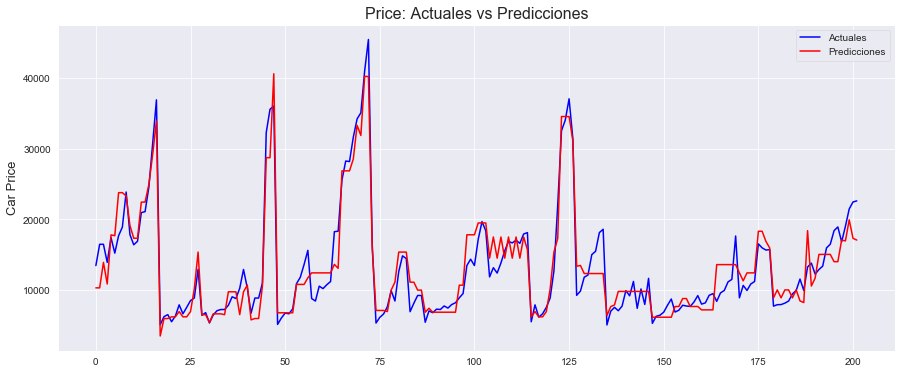

In [363]:
fig, ax=plt.subplots(figsize=(15,6))
sns.lineplot(x=y_new_cv.index,y=y_new_cv,label='Actuales',color='blue',ax=ax)
sns.lineplot(x=y_new_cv.index,y=y_predictions,label='Predicciones',color='red',ax=ax)
ax.set_title('Price: Actuales vs Predicciones', fontsize=16)
ax.set_ylabel('Price',fontsize=13)

El gráfico muestra que las predicciones pierden un poco los valores reales en algunos lugares, pero dado que queremos evitar el sobreajuste y que nuestro modelo se generalice bien y funcione bien en datos de prueba no vistos, tendremos que comprometer un poco (compensación de variación de sesgo)

## Revisión de loa supuestos del nuevo modelo

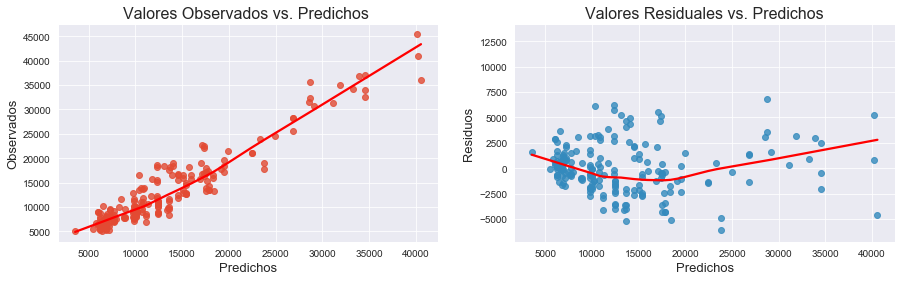

In [364]:
linearity_test(lm_sm,y_new_cv)
# La linealidad parece cumplirse

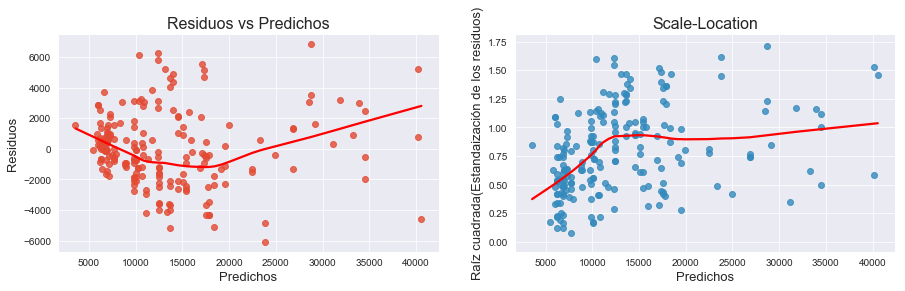

In [365]:
homoscedasticity_test(lm_sm)
#Son homocedasticos

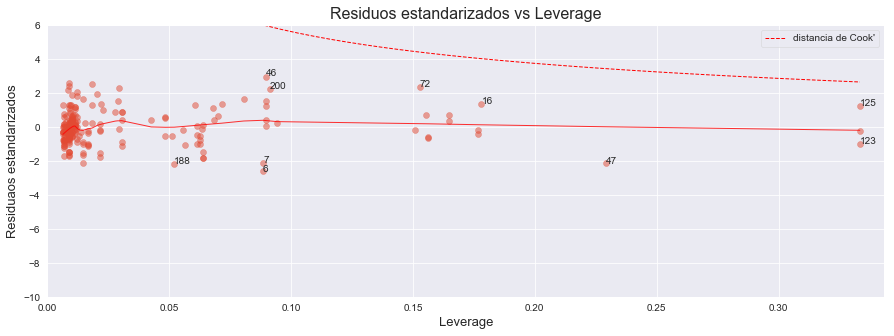

In [366]:
influential_outlier_test(model=lm_sm,top_influencing_obs_count=10)

#Ningún outlier

Jarque-Bera test ---- Estadístico: 3.6300, p-value: 0.1628415001037472
Shapiro-Wilk test ---- Estadístico: 0.9867, p-value: 0.0545
Kolmogorov-Smirnov test ---- Estadístico: 0.5297, p-value: 0.0000
Anderson-Darling test ---- Estadístico: 0.8954, 5% valor crítico: 0.7720


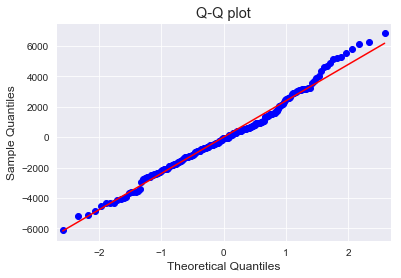

In [368]:
normality_of_residuals_test(lm_sm)
# Existe evidencia para considerar que no son normales por un par de test, pero el gráfico luce muy bien salvo la cola superior

# El modelo final cumple con los supuestos y posee un R2=0.91% y RMSE=2390